In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt 


In [ ]:
# from torchattacks import RPGD

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = '/gdrive/My Drive/ReLU_defense/models/lenet_mnist_model.pth' #pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

In [13]:
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# simply define a silu function
def srelu(input, slope):
    return slope * F.relu(input)

class SReLU(nn.Module):
    def __init__(self):
        super().__init__() # init the base class

    def forward(self, input, slope):
        return srelu(input, slope) # simply apply already implemented SiLU

In [6]:
# LeNet Model definition
class NetTest(nn.Module):
    def __init__(self, slope):
        super(NetTest, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.slope = slope

    def forward(self, x):
#         s = torch.tensor(.7, requires_grad=False)        
        x = srelu(F.max_pool2d(self.conv1(x), 2), self.slope)
        x = srelu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2), self.slope)    
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = srelu(self.fc1(x), self.slope)
#         x = F.relu(self.fc1(x))        
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # *********** use this with nll_loss!

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")



CUDA Available:  True


In [7]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=False)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def test( model, device, test_loader, epsilon, myTarget):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target, myTarget = data.to(device), target.to(device), myTarget.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        if init_pred.item() == myTarget.item():            
            continue

        # Calculate the loss
        # loss = F.nll_loss(output, target)

        loss = F.nll_loss(output, myTarget)        

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, -1*data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == myTarget.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
#         else:
#             # Save some adv examples for visualization later
#             if len(adv_examples) < 5:
#                 adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                 adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples


 Running digit=0 slope=0.5 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 57 / 10000 = 0.0057
Epsilon: 0.1	Test Accuracy = 157 / 10000 = 0.0157
Epsilon: 0.15	Test Accuracy = 335 / 10000 = 0.0335
Epsilon: 0.2	Test Accuracy = 641 / 10000 = 0.0641
Epsilon: 0.25	Test Accuracy = 909 / 10000 = 0.0909
Epsilon: 0.3	Test Accuracy = 1104 / 10000 = 0.1104

 Running digit=0 slope=1 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 34 / 10000 = 0.0034
Epsilon: 0.1	Test Accuracy = 129 / 10000 = 0.0129
Epsilon: 0.15	Test Accuracy = 358 / 10000 = 0.0358
Epsilon: 0.2	Test Accuracy = 737 / 10000 = 0.0737
Epsilon: 0.25	Test Accuracy = 1189 / 10000 = 0.1189
Epsilon: 0.3	Test Accuracy = 1520 / 10000 = 0.152

 Running digit=0 slope=2 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 34 / 10000 = 0.0034
Epsilon: 0.1	Test Accuracy = 109 / 10000 = 0.0109
Epsilon: 0.15	Test Accuracy = 265 / 10000 = 0.0265
Epsilon: 0.2	Test A

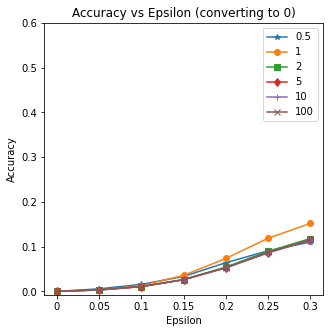


 Running digit=1 slope=0.5 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 140 / 10000 = 0.014
Epsilon: 0.1	Test Accuracy = 439 / 10000 = 0.0439
Epsilon: 0.15	Test Accuracy = 1201 / 10000 = 0.1201
Epsilon: 0.2	Test Accuracy = 2554 / 10000 = 0.2554
Epsilon: 0.25	Test Accuracy = 3732 / 10000 = 0.3732
Epsilon: 0.3	Test Accuracy = 4545 / 10000 = 0.4545

 Running digit=1 slope=1 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 41 / 10000 = 0.0041
Epsilon: 0.1	Test Accuracy = 151 / 10000 = 0.0151
Epsilon: 0.15	Test Accuracy = 451 / 10000 = 0.0451
Epsilon: 0.2	Test Accuracy = 1002 / 10000 = 0.1002
Epsilon: 0.25	Test Accuracy = 1758 / 10000 = 0.1758
Epsilon: 0.3	Test Accuracy = 2447 / 10000 = 0.2447

 Running digit=1 slope=2 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 37 / 10000 = 0.0037
Epsilon: 0.1	Test Accuracy = 108 / 10000 = 0.0108
Epsilon: 0.15	Test Accuracy = 291 / 10000 = 0.0291
Epsilon: 0.2	T

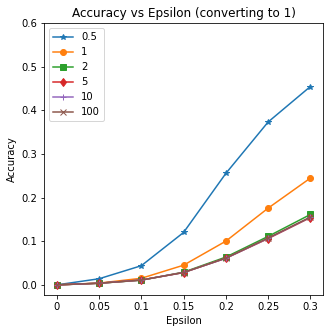


 Running digit=2 slope=0.5 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 120 / 10000 = 0.012
Epsilon: 0.1	Test Accuracy = 275 / 10000 = 0.0275
Epsilon: 0.15	Test Accuracy = 586 / 10000 = 0.0586
Epsilon: 0.2	Test Accuracy = 1247 / 10000 = 0.1247
Epsilon: 0.25	Test Accuracy = 2196 / 10000 = 0.2196
Epsilon: 0.3	Test Accuracy = 3225 / 10000 = 0.3225

 Running digit=2 slope=1 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 111 / 10000 = 0.0111
Epsilon: 0.1	Test Accuracy = 381 / 10000 = 0.0381
Epsilon: 0.15	Test Accuracy = 1129 / 10000 = 0.1129
Epsilon: 0.2	Test Accuracy = 2852 / 10000 = 0.2852
Epsilon: 0.25	Test Accuracy = 5067 / 10000 = 0.5067
Epsilon: 0.3	Test Accuracy = 6746 / 10000 = 0.6746

 Running digit=2 slope=2 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 118 / 10000 = 0.0118
Epsilon: 0.1	Test Accuracy = 370 / 10000 = 0.037
Epsilon: 0.15	Test Accuracy = 1108 / 10000 = 0.1108
Epsilon: 0.2

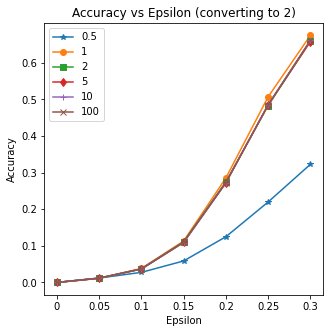


 Running digit=3 slope=0.5 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 72 / 10000 = 0.0072
Epsilon: 0.1	Test Accuracy = 116 / 10000 = 0.0116
Epsilon: 0.15	Test Accuracy = 171 / 10000 = 0.0171
Epsilon: 0.2	Test Accuracy = 306 / 10000 = 0.0306
Epsilon: 0.25	Test Accuracy = 627 / 10000 = 0.0627
Epsilon: 0.3	Test Accuracy = 1124 / 10000 = 0.1124

 Running digit=3 slope=1 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 63 / 10000 = 0.0063
Epsilon: 0.1	Test Accuracy = 250 / 10000 = 0.025
Epsilon: 0.15	Test Accuracy = 798 / 10000 = 0.0798
Epsilon: 0.2	Test Accuracy = 1928 / 10000 = 0.1928
Epsilon: 0.25	Test Accuracy = 3496 / 10000 = 0.3496
Epsilon: 0.3	Test Accuracy = 4529 / 10000 = 0.4529

 Running digit=3 slope=2 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 68 / 10000 = 0.0068
Epsilon: 0.1	Test Accuracy = 273 / 10000 = 0.0273
Epsilon: 0.15	Test Accuracy = 783 / 10000 = 0.0783
Epsilon: 0.2	Test 

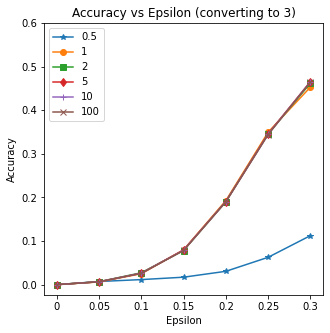


 Running digit=4 slope=0.5 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 75 / 10000 = 0.0075
Epsilon: 0.1	Test Accuracy = 170 / 10000 = 0.017
Epsilon: 0.15	Test Accuracy = 392 / 10000 = 0.0392
Epsilon: 0.2	Test Accuracy = 794 / 10000 = 0.0794
Epsilon: 0.25	Test Accuracy = 1392 / 10000 = 0.1392
Epsilon: 0.3	Test Accuracy = 1850 / 10000 = 0.185

 Running digit=4 slope=1 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 70 / 10000 = 0.007
Epsilon: 0.1	Test Accuracy = 281 / 10000 = 0.0281
Epsilon: 0.15	Test Accuracy = 771 / 10000 = 0.0771
Epsilon: 0.2	Test Accuracy = 1523 / 10000 = 0.1523
Epsilon: 0.25	Test Accuracy = 2284 / 10000 = 0.2284
Epsilon: 0.3	Test Accuracy = 2904 / 10000 = 0.2904

 Running digit=4 slope=2 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 72 / 10000 = 0.0072
Epsilon: 0.1	Test Accuracy = 267 / 10000 = 0.0267
Epsilon: 0.15	Test Accuracy = 701 / 10000 = 0.0701
Epsilon: 0.2	Test A

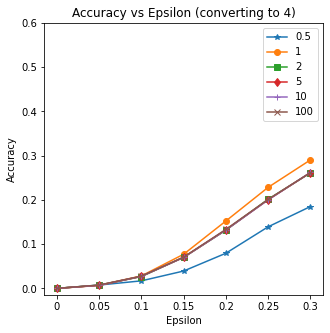


 Running digit=5 slope=0.5 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 316 / 10000 = 0.0316
Epsilon: 0.1	Test Accuracy = 867 / 10000 = 0.0867
Epsilon: 0.15	Test Accuracy = 1892 / 10000 = 0.1892
Epsilon: 0.2	Test Accuracy = 3404 / 10000 = 0.3404
Epsilon: 0.25	Test Accuracy = 4764 / 10000 = 0.4764
Epsilon: 0.3	Test Accuracy = 5669 / 10000 = 0.5669

 Running digit=5 slope=1 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 89 / 10000 = 0.0089
Epsilon: 0.1	Test Accuracy = 357 / 10000 = 0.0357
Epsilon: 0.15	Test Accuracy = 1080 / 10000 = 0.108
Epsilon: 0.2	Test Accuracy = 2418 / 10000 = 0.2418
Epsilon: 0.25	Test Accuracy = 4006 / 10000 = 0.4006
Epsilon: 0.3	Test Accuracy = 5296 / 10000 = 0.5296

 Running digit=5 slope=2 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 69 / 10000 = 0.0069
Epsilon: 0.1	Test Accuracy = 264 / 10000 = 0.0264
Epsilon: 0.15	Test Accuracy = 767 / 10000 = 0.0767
Epsilon: 0.2	

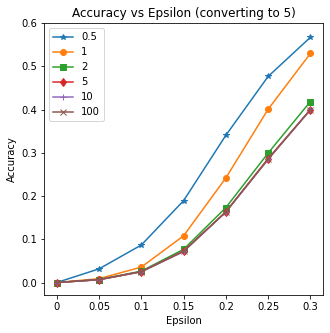


 Running digit=6 slope=0.5 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 86 / 10000 = 0.0086
Epsilon: 0.1	Test Accuracy = 126 / 10000 = 0.0126
Epsilon: 0.15	Test Accuracy = 154 / 10000 = 0.0154
Epsilon: 0.2	Test Accuracy = 174 / 10000 = 0.0174
Epsilon: 0.25	Test Accuracy = 190 / 10000 = 0.019
Epsilon: 0.3	Test Accuracy = 207 / 10000 = 0.0207

 Running digit=6 slope=1 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 52 / 10000 = 0.0052
Epsilon: 0.1	Test Accuracy = 180 / 10000 = 0.018
Epsilon: 0.15	Test Accuracy = 423 / 10000 = 0.0423
Epsilon: 0.2	Test Accuracy = 871 / 10000 = 0.0871
Epsilon: 0.25	Test Accuracy = 1542 / 10000 = 0.1542
Epsilon: 0.3	Test Accuracy = 2249 / 10000 = 0.2249

 Running digit=6 slope=2 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 90 / 10000 = 0.009
Epsilon: 0.1	Test Accuracy = 255 / 10000 = 0.0255
Epsilon: 0.15	Test Accuracy = 587 / 10000 = 0.0587
Epsilon: 0.2	Test Accu

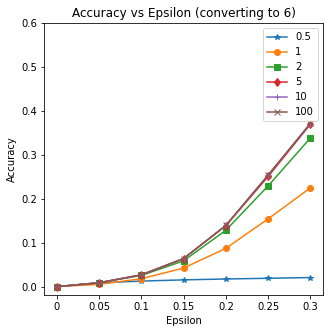


 Running digit=7 slope=0.5 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 91 / 10000 = 0.0091
Epsilon: 0.1	Test Accuracy = 139 / 10000 = 0.0139
Epsilon: 0.15	Test Accuracy = 178 / 10000 = 0.0178
Epsilon: 0.2	Test Accuracy = 245 / 10000 = 0.0245
Epsilon: 0.25	Test Accuracy = 403 / 10000 = 0.0403
Epsilon: 0.3	Test Accuracy = 579 / 10000 = 0.0579

 Running digit=7 slope=1 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 62 / 10000 = 0.0062
Epsilon: 0.1	Test Accuracy = 155 / 10000 = 0.0155
Epsilon: 0.15	Test Accuracy = 449 / 10000 = 0.0449
Epsilon: 0.2	Test Accuracy = 1072 / 10000 = 0.1072
Epsilon: 0.25	Test Accuracy = 1722 / 10000 = 0.1722
Epsilon: 0.3	Test Accuracy = 1996 / 10000 = 0.1996

 Running digit=7 slope=2 ... 
Epsilon: 0	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 65 / 10000 = 0.0065
Epsilon: 0.1	Test Accuracy = 183 / 10000 = 0.0183
Epsilon: 0.15	Test Accuracy = 480 / 10000 = 0.048
Epsilon: 0.2	Test A

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
slopes   = [.5, 1, 2, 5, 10, 100]
symbs = ['*-', 'o-', 's-', 'd-', '+-', 'x-', '^-', '<-']


all_all_accuracies = []

for num in range(10):

    all_accuracies = []
    all_examples = []

    # Run test for each slope
    for sl in slopes:
        print(f'\n Running digit={num} slope={sl} ... ')
        # Initialize the network
        model = NetTest(sl).to(device)

        # Load the pretrained model
        model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

        # Set the model in evaluation mode. In this case this is for the Dropout layers
        model.eval()

        # Run test for each epsilon
        def_accuracies = []
        def_examples = []
    #     myTarget = torch.tensor([2])    
        for eps in epsilons:
            myTarget = torch.tensor([num]) #torch.randint(10, (1,1)).squeeze(0)        
    #         myTarget = torch.randint(10, (1,1)).squeeze(0)                
            acc, ex = test(model, device, test_loader, eps, myTarget)
            def_accuracies.append(acc)
#             def_examples.append(ex)

        all_accuracies.append(def_accuracies)
#         all_examples.append(def_examples)

    all_all_accuracies.append(all_accuracies)
    
    all_accuracies = np.array(all_accuracies)
    # all_accuracies = all_accuracies.T    
    fig =plt.figure(figsize=(5,5))
    for idx in range(len(all_accuracies)):
        plt.plot(all_accuracies[idx,:], symbs[idx])

    #     plt.plot(epsilons, np.array(all_accuracies).T, "*-")
    plt.yticks(np.arange(0, .7, step=0.1))
    plt.xticks(np.arange(0, len(epsilons), step=1), epsilons)
    plt.title(f"Accuracy vs Epsilon (converting to {num})")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.legend(slopes)
    plt.show()
    fig.savefig(f'/gdrive/My Drive/ReLU_defense/Tmp/Targeted/plot-{num}.png')

np.save(all_all_accuracies,'/gdrive/My Drive/ReLU_defense/Tmp/accs_MNIST_targeted.npy')


In [ ]:
range(len(all_accuracies))

NameError: ignored

In [22]:
!ls '/gdrive/My Drive'

'Getting started.pdf'   ReLU_defense


In [ ]:
all_res = np.array(all_all_accuracies)
all_res_m = all_res.mean(axis=0).T

NameError: ignored

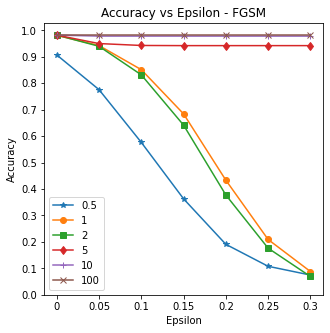

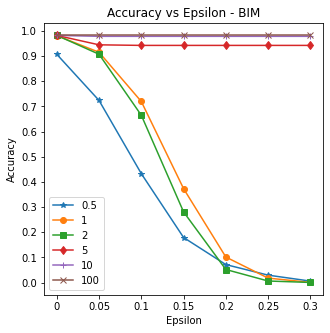

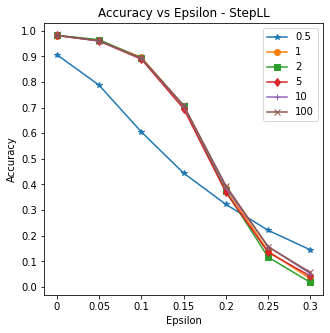

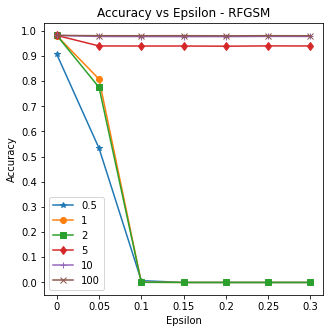

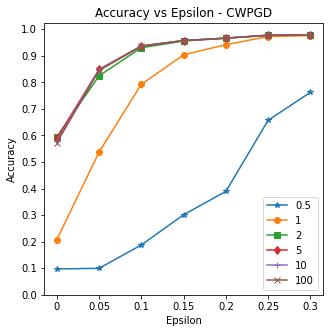

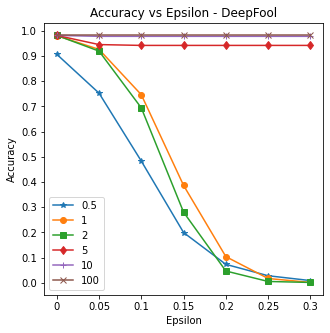

In [ ]:
fig =plt.figure(figsize=(5,5))
for idx in range(1,len(all_res_m)):
    plt.plot(all_res_m[:,idx], symbs[idx])

#     plt.plot(epsilons, np.array(all_accuracies).T, "*-")
plt.yticks(np.arange(0, .7, step=0.1))
plt.xticks(np.arange(0, 7, step=1), epsilons)
plt.title(f"Accuracy vs Epsilon (Avg. over digits)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(slopes[1:])
plt.show()
fig.savefig(f'avg.png')


In [ ]:
torch.save(all_all_accuracies,'/gdrive/My Drive/Tmp/accs_MNISTz.npy')

In [ ]:
model = NetTest(1).to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model.eval()

# Run test for each epsilon
def_accuracies = []
def_examples = []

eps = .2

myTarget = torch.tensor([6]) #torch.randint(10, (1,1)).squeeze(0)        
acc, ex = test(model, device, test_loader, eps, myTarget)
def_accuracies.append(acc)
def_examples.append(ex)

    
    

Epsilon: 0.2	Test Accuracy = 871 / 10000 = 0.0871


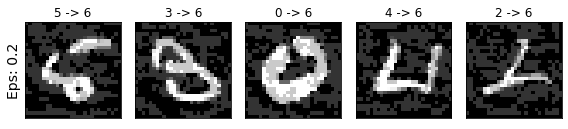

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for j in range(len(def_examples[0])):
    cnt += 1
    if len(def_examples[0]) ==1:
        continue
    plt.subplot(1,len(def_examples[0]),cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    if j == 0:
        plt.ylabel("Eps: {}".format(eps), fontsize=14)
    orig,adv,ex = def_examples[0][j]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()